## Importing Libraries

In [377]:
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)


import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import math
from scipy.stats import zscore, iqr
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import learning_curve
from scipy.stats import f_oneway
from sklearn.feature_selection import mutual_info_regression

## 1. Data Loading

In [378]:
df = pd.read_csv('data/data.csv')

## 2. Data Proprocessing

### 2.1 Data Exploring

In [379]:
df.shape

(8128, 12)

In [380]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


In [381]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                8128 non-null   object 
 1   year                8128 non-null   int64  
 2   selling_price       8128 non-null   int64  
 3   km_driven           8128 non-null   int64  
 4   fuel                8128 non-null   object 
 5   seller_type         8128 non-null   object 
 6   transmission        8128 non-null   object 
 7   owner               8128 non-null   object 
 8   mileage(km/ltr/kg)  7907 non-null   float64
 9   engine              7907 non-null   float64
 10  max_power           7913 non-null   object 
 11  seats               7907 non-null   float64
dtypes: float64(3), int64(3), object(6)
memory usage: 762.1+ KB


### 2.2 Data Cleaning

In [382]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage(km/ltr/kg)', 'engine', 'max_power',
       'seats'],
      dtype='object')

In [383]:
df.drop(columns='name', inplace=True)

In [384]:
df.columns = ['year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats']

In [385]:
df.duplicated().sum()

np.int64(1221)

In [386]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [387]:
df['max_power'] = df['max_power'].replace({' ': np.nan})
df['max_power'] = df['max_power'].astype(float)

In [388]:
df[['selling_price','km_driven']] = df[['selling_price','km_driven']].astype(float)

In [389]:
df.isnull().sum()

year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          208
engine           208
max_power        206
seats            208
dtype: int64

In [390]:
df[df.isnull().any(axis=1)]

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
13,2007,200000.0,80000.0,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN
31,2003,70000.0,50000.0,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN
78,2003,50000.0,70000.0,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN
87,2015,475000.0,78000.0,Diesel,Dealer,Manual,First Owner,NaN,NaN,NaN,NaN
119,2010,300000.0,120000.0,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6616,2004,70000.0,70000.0,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN
6778,2000,140000.0,50000.0,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN
6791,2006,145000.0,80000.0,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN
6850,2017,580000.0,165000.0,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN


### 2.3 Data Visualization

In [391]:
float_cols = df.select_dtypes(include=[float]).columns

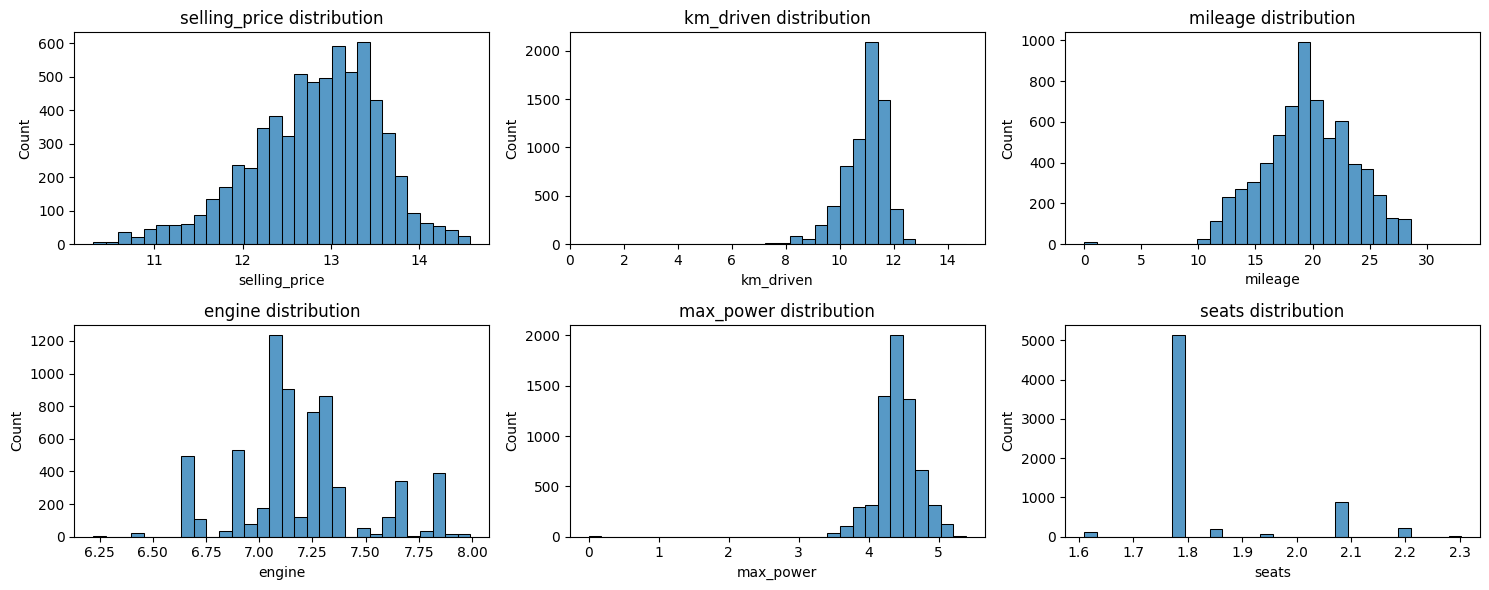

In [421]:
def plot_hist(df, columns, n_cols=3):
    n_rows = math.ceil(len(columns) / n_cols)
    figsize = (15, 3 * n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(df[col], bins=30, ax=axes[i])
        axes[i].set_title(f'{col} distribution')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_hist(df, float_cols)

### 2.4 Missing Values Imputation

In [393]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer()
df[['mileage','engine','max_power','seats']] = pd.DataFrame(imputer.fit_transform(df[['mileage','engine','max_power','seats']]), columns=['mileage','engine','max_power','seats'])

### 2.5 Outlier Handling

In [394]:
def iqr_outliers(df, columns, iqr_factor=1.5, remove=False, return_index = False):
    outliers_info = {}
    outliers_indexs = set()

    for column in columns:
        Q1 = np.percentile(df[column].dropna(), 25)
        Q3 = np.percentile(df[column].dropna(), 75)
        IQR = iqr(df[column].dropna())

        lim_inf = Q1 - iqr_factor * IQR
        lim_sup = Q3 + iqr_factor * IQR
        outliers = df[(df[column] < lim_inf) | (df[column] > lim_sup)]

        if not outliers.empty:
          outliers_info[column] = len(outliers)
          outliers_indexs.update(outliers.index)

    df_results = pd.DataFrame(outliers_info, index=['outliers']).T
    
    if remove:
        df.drop(index=outliers_indexs, inplace=True)
        df.reset_index(drop=True,inplace=True)
        print(f'\n{len(outliers_indexs)} were removed.')
    
    print(f'{len(outliers_indexs)} outliers')
    print(df_results)
    
    if return_index:
        return outliers_indexs

def plot_boxplots(df, columns, n_cols=3, figsize=(5, 4)):
    n_rows = math.ceil(len(columns) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, column in enumerate(columns):
        df.boxplot(column=column, ax=axes[i])
        axes[i].set_title(column)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def z_score_outliers(df, cols, threshold=3, remove=False, return_index=False):
    outliers_info = {}
    outliers_indexs = set()

    for col in cols:
        z_scores = zscore(df[col].dropna())

        outliers = df[col][(z_scores > threshold) | (z_scores < -threshold)]

        if not outliers.empty:
            outliers_info[col] = len(outliers)
            outliers_indexs.update(outliers.index)
 
    df_results = pd.DataFrame(outliers_info, index=['outliers']).T

    if remove:
        df.drop(index=outliers_indexs, inplace=True)
        df.reset_index(drop=True,inplace=True)
        print(f'\n{len(outliers_indexs)} were removed.')
    
    print(f'{len(outliers_indexs)} outliers')
    
    print(df_results)
    
    if return_index:
        return outliers_indexs

def isolation_forest_outliers(df, columns, contamination=0.05, remove=False, return_index=False):
    
    iso_for = IsolationForest(contamination=contamination)
    df_copy = df.copy()
    df_copy['outlier_score'] = iso_for.fit_predict(df_copy[columns])
    
    outliers = df_copy[df_copy['outlier_score'] == -1]
    outliers_index = outliers.index.tolist()

    if remove:
        df.drop(index=outliers_index, inplace=True)
        df.reset_index(drop=True,inplace=True)
        print(f'{len(outliers_index)} were dropped')

    print(f'{len(outliers)} outliers')
    
    if return_index:
        return outliers_index

In [395]:
iqr_index = iqr_outliers(df, float_cols, iqr_factor=1.5,return_index=True)

2032 outliers
               outliers
selling_price       327
km_driven           166
mileage              23
engine             1206
max_power           374
seats              1667


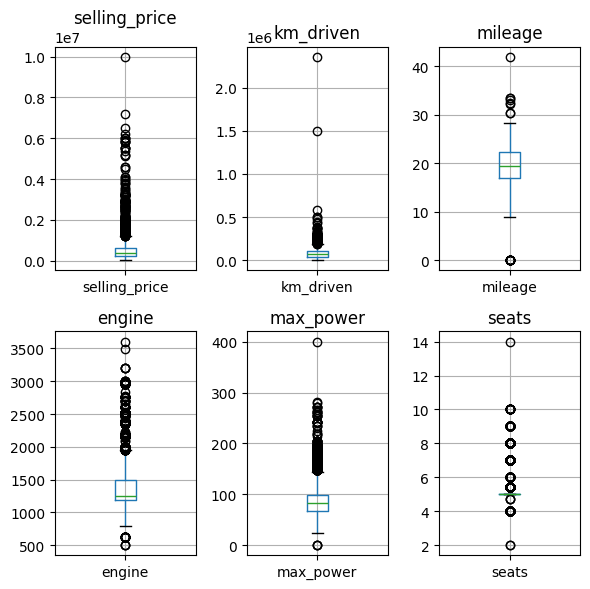

In [396]:
plot_boxplots(df, float_cols, n_cols=3, figsize=(6, 6))

In [397]:
z_index = z_score_outliers(df, float_cols, threshold=3,return_index=True)

373 outliers
               outliers
selling_price       107
km_driven            60
mileage              21
engine               89
max_power           115
seats                95


In [398]:
iso_index = isolation_forest_outliers(df, float_cols, return_index=True)

346 outliers


In [399]:
outliers_index = pd.Index(iqr_index).intersection(pd.Index(iso_index)).intersection(pd.Index(z_index))

*In this step, I am identifying the outlier indices using IQR, Isolation Forest and Z-Score methods to remove these outliers. Specifically, I am intercepting the outliers identified by these three methods.*

In [400]:
df.drop(index=outliers_index, inplace=True)
df.reset_index(drop=True, inplace=True)

### 2.6 Feature Engineering

#### 2.6.1 Feature Selection

##### Continous -> Continous

In [401]:
def corr_pearson(df, features,target , method='pearson', show_plot=False):
    
    float_cols = features.append(pd.Index([target]))
    df = df[float_cols]
    corr_info = df.corr(method=method)

    if show_plot:
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_info, annot=True, cmap='coolwarm', center=0)
        plt.show()
    else:
        corr_info = corr_info[target].sort_values(ascending=False)
        return corr_info

In [402]:
def corr_spearman(df,features,target):

    corr_info = []

    for feature in features:
        spearman_corr = df[feature].corr(df[target], method="spearman")
        corr_info.append({
            "Feature": feature,
            "Spearman Correlation": spearman_corr
        })
    
    return pd.DataFrame(corr_info).sort_values('Spearman Correlation', ascending=False)

In [403]:
def mutual_info(df, features, target):
    results = mutual_info_regression(df[features], df[target])
    results = pd.Series(results, index=features)
    return results.sort_values(ascending=False)

In [404]:
float_features = float_cols.drop('selling_price')

In [405]:
corr_pearson(df, float_features, 'selling_price', show_plot=False)

selling_price    1.000000
max_power        0.623404
engine           0.435897
seats            0.292126
mileage         -0.018943
km_driven       -0.193640
Name: selling_price, dtype: float64

In [406]:
corr_spearman(df,float_features , 'selling_price')

,Feature,Spearman Correlation
3,max_power,0.584587
2,engine,0.425075
4,seats,0.265432
1,mileage,0.087216
0,km_driven,-0.289090


In [407]:
mutual_info(df,float_features , 'selling_price')

max_power    0.698727
mileage      0.547118
engine       0.453757
seats        0.124282
km_driven    0.068548
dtype: float64

##### categorical -> continous

In [408]:
def one_way_anova(df, features, target, return_results = False):
    results = []
    important_features = []
    no_important_features = []

    for feature in features:
        groups = [df[df[feature] == group][target].dropna() for group in df[feature].unique()]
        f_stat, p_value = f_oneway(*groups)

        if p_value < 0.05:
            important_features.append(feature)
            is_important = True
        else:
            no_important_features.append(feature)
            is_important = False
        
        results.append({
            "Feature": feature,
            "F-Statistic": f_stat,
            "P-Value": p_value,
            "Is Important": is_important
        })

    result_df = pd.DataFrame(results).sort_values('P-Value')

    if return_results:
        print(",".join(important_features))
        return important_features, no_important_features
    else:
        return result_df

In [409]:
categorical_features = df.select_dtypes(include=['int', 'object']).columns

In [410]:
one_way_anova(df, categorical_features, 'selling_price', return_results=False)

,Feature,F-Statistic,P-Value,Is Important
0,year,150.998475,0.000000e+00,True
4,owner,233.574184,6.209872e-188,True
1,fuel,278.773138,1.947029e-170,True
3,transmission,547.027574,2.517506e-116,True
2,seller_type,145.593934,1.306070e-62,True


##### Selecting the important features

*In this situation, we can say that `mileage` does not have a linear relationship with the target: `selling_price`, but they have a good value of mutual information, so `mileage` and `selling_price` have a complex relationship*

*So, in this case, I don't drop any variable because the other variables have an impact in the target variable*

#### 2.6.2 Feature Transformation

In [411]:
from datetime import datetime

year = datetime.now().year
df['year'] = year - df['year']

In [422]:
from scipy.stats import skew, kurtosis

def verify_normality(df, columns, return_no_normal=False):
    results = []
    no_normal = []
    for col in columns:
        skewness = skew(df[col])
        excess_kurtosis = kurtosis(df[col])
        
        index = abs(skewness) + abs(excess_kurtosis)
        if index < 0.5:
            interpretation = "Close"
        elif index < 1:
            interpretation = "Moderately"
        else:
            interpretation = "Far"
            no_normal.append(col)
        
        results.append([col, index, interpretation])
    
    normality_df = pd.DataFrame(results, columns=["Column", "Normality Index", "Interpretation"])
    print(normality_df)
    
    if return_no_normal:
        return no_normal

In [423]:
no_normal_cols = verify_normality(df, float_cols)

          Column  Normality Index Interpretation
0  selling_price         0.761623     Moderately
1      km_driven         7.256669            Far
2        mileage         0.604843     Moderately
3         engine         0.636714     Moderately
4      max_power        19.792470            Far
5          seats         3.428723            Far


In [416]:
def log1p_transform(df, columns):
    for col in columns:
        df[col] = np.log1p(df[col])

In [420]:
log1p_transform(df, no_normal_cols)

### 2.7 Feature Encoding

In [424]:
categorical_features = df.select_dtypes(include=['object']).columns

In [425]:
categorical_features

Index(['fuel', 'seller_type', 'transmission', 'owner'], dtype='object')

In [426]:
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

### 2.8 Feature Scaling

## 3. Machine Learning Models

In [428]:
regression_metrics = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R²'])
y_pred_dict = {}

def save_metrics(model, y_test, y_pred):
    global regression_metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    y_pred_dict[model] = y_pred
    
    new_row = {
        'Model': model,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }
    
    new_row_df = pd.DataFrame([new_row]).dropna(axis=1, how='all')
    regression_metrics = pd.concat([regression_metrics, new_row_df], ignore_index=True)

In [429]:
x = df.drop(columns='selling_price')
y = df['selling_price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [430]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Bagging Regressor': BaggingRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'AdaBoost Regressor': AdaBoostRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
}

In [431]:
def model_testing(models, x_train, x_test, y_train, y_test):
    for model in models:
        models[model].fit(x_train, y_train)
        y_pred = models[model].predict(x_test)
        save_metrics(model, y_test, y_pred)

In [432]:
model_testing(models, x_train, x_test, y_train, y_test)

C:\Users\harol\AppData\Local\Temp\ipykernel_32472\3025566654.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regression_metrics = pd.concat([regression_metrics, new_row_df], ignore_index=True)


## 4. Model Evaluation

In [433]:
regression_metrics

,Model,MAE,MSE,RMSE,R²,MAPE
0,Linear Regression,0.228117,0.086182,0.293568,0.835567,0.018054
1,Lasso,0.426197,0.288749,0.537354,0.449074,0.033687
2,Ridge,0.228168,0.086208,0.293613,0.835517,0.018058
3,ElasticNet,0.390882,0.243590,0.493549,0.535236,0.030798
4,Decision Tree Regressor,0.214367,0.090008,0.300013,0.828267,0.017053
5,Bagging Regressor,0.171617,0.055772,0.236160,0.893589,0.013595
6,Random Forest Regressor,0.165636,0.050741,0.225258,0.903187,0.013143
7,AdaBoost Regressor,0.274408,0.117596,0.342922,0.775630,0.021436
8,Gradient Boosting Regressor,0.179208,0.057066,0.238884,0.891120,0.014195


In [434]:
def plot_residuals(y_test, y_pred_dict):
    n_preds = len(y_pred_dict)
    n_cols = 4
    n_rows = (n_preds + n_cols - 1) // n_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axes = axes.flatten()

    for i, (name, y_pred) in enumerate(y_pred_dict.items()):
        residuals = y_test - y_pred
        sns.histplot(residuals, kde=True, bins=30, ax=axes[i])
        axes[i].set_title(f"{name}")
        axes[i].set_xlabel("Residuals")
        axes[i].set_ylabel("Frequency")
        axes[i].axvline(0, color='red', linestyle='--')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

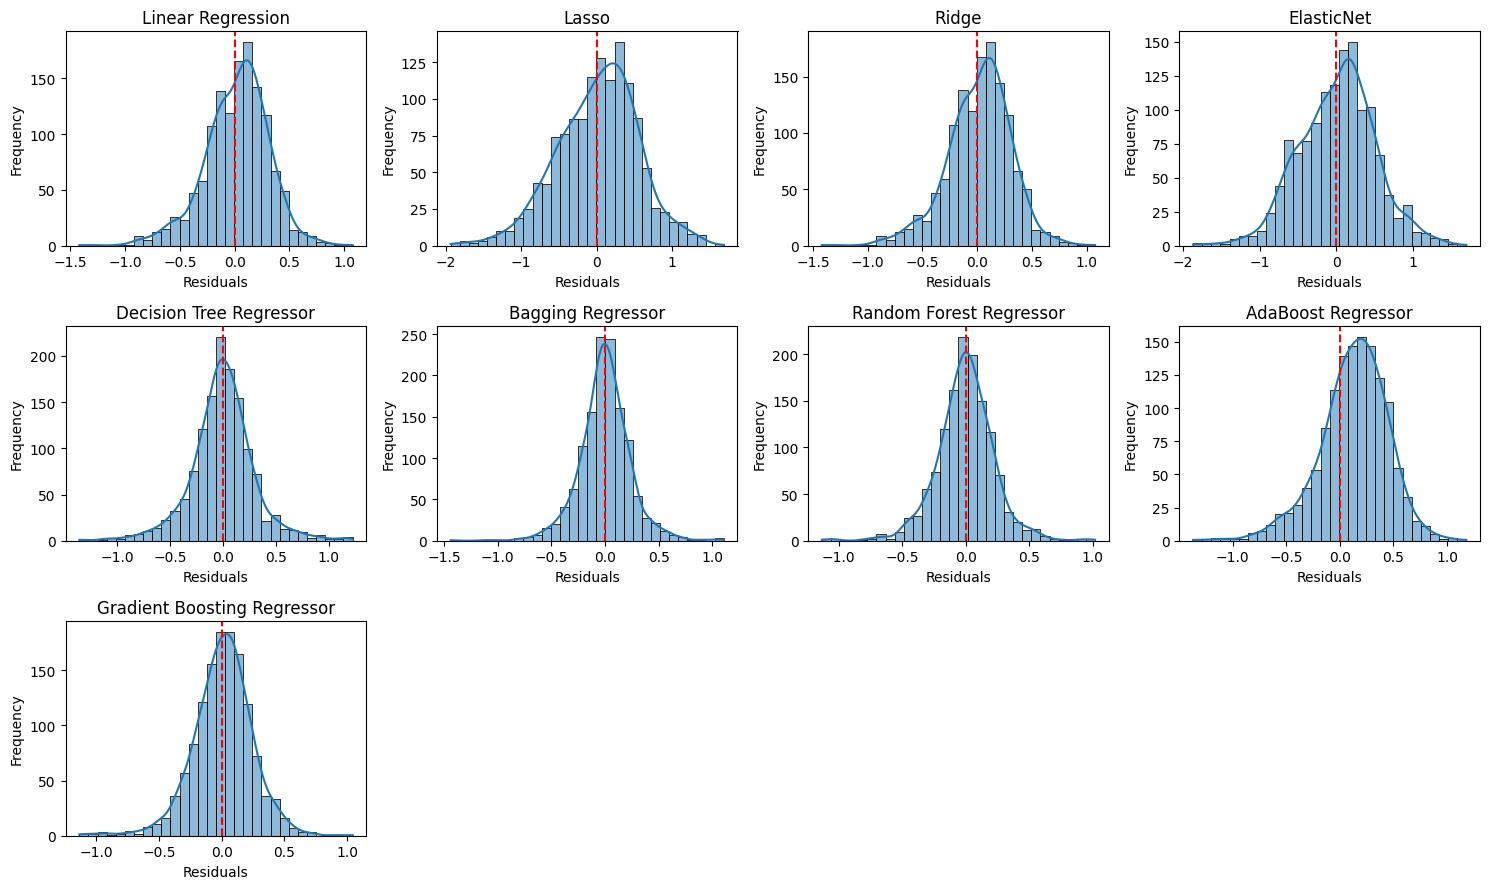

In [435]:
plot_residuals(y_test, y_pred_dict)

In [436]:
def scatter_plot(y_test, y_preds_dict):
    n_preds = len(y_preds_dict)
    n_cols = 4
    n_rows = (n_preds + n_cols - 1) // n_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axes = axes.flatten()

    for i, (name, y_pred) in enumerate(y_preds_dict.items()):
        plt.sca(axes[i])
        plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # diagonal
        plt.title(f'{name}')
        plt.xlabel('True Values')
        plt.ylabel('Predict Values')
        plt.grid(True)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

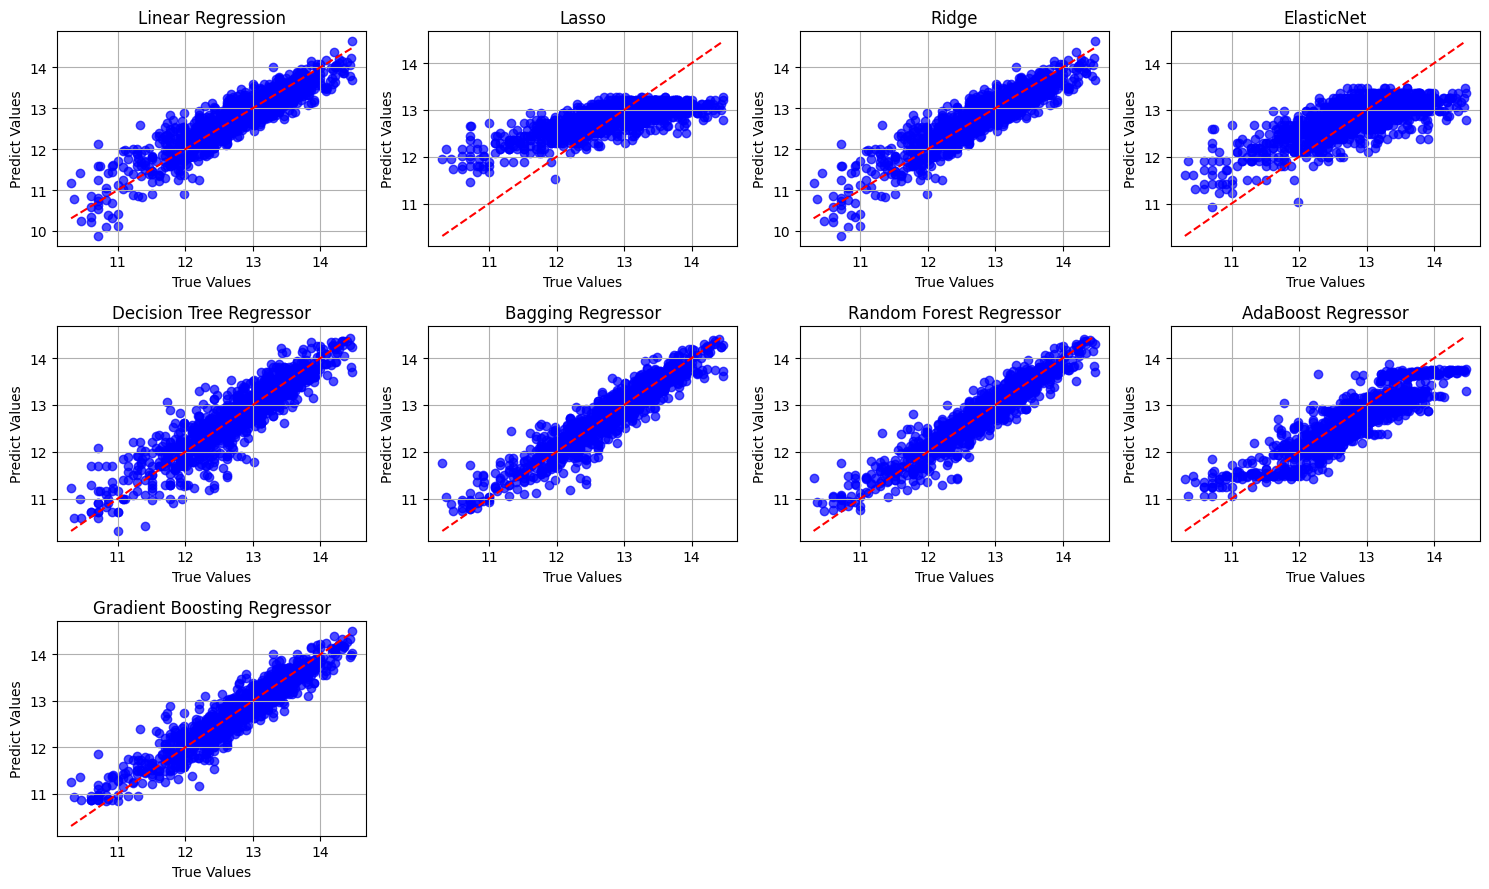

In [437]:
scatter_plot(y_test, y_pred_dict)

## 5. Model Optimization

### 5.1 Hyperparameter Tuning

In [438]:
param_dist = {
    'Linear Regression': {
        'fit_intercept': [True, False],
    },
    'Lasso': {
        'alpha': np.logspace(-4, 0, 50),  # Explora valores desde 1e-4 hasta 1 en escala logarítmica
        'max_iter': [1000, 2000, 3000],
        'tol': np.logspace(-5, -3, 5)  # Por ejemplo, de 1e-5 a 1e-3
    },
    'Ridge': {
        'alpha': np.logspace(-4, 2, 100),  # Desde 1e-4 hasta 1e2
        'fit_intercept': [True, False],
        'tol': np.logspace(-5, -3, 100),
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        'max_iter': np.arange(100, 1000, 100),
    },
    'ElasticNet': {
        'alpha': np.logspace(-4, 0, 50),
        'l1_ratio': np.linspace(0.1, 1.0, 10),  # Más opciones entre 0.1 y 1
        'max_iter': [1000, 2000, 3000],
        'tol': np.logspace(-5, -3, 5)
    },
    'Decision Tree Regressor': {
        'max_depth': [None, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    },
    'Bagging Regressor': {
        'n_estimators': [50, 100, 150, 200],
        'max_samples': [0.5, 0.7, 1.0],
        'max_features': [0.5, 0.7, 1.0]
    },
    'Random Forest Regressor': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [None, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'Gradient Boosting Regressor': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': np.logspace(-3, -1, 5)  # Desde 0.001 hasta 0.1
    },
    'AdaBoost Regressor': {
        'n_estimators': [50, 100, 150, 200],
        'learning_rate': np.linspace(0.5, 1.0, 6),
        'loss': ['linear', 'square', 'exponential']
    }
}


In [439]:
y_pred_dict = {}
models_pro = {}

def regression_hyperparameter_tuning(x, y, models, param_dist,n_iter = 100, cv=5, scoring='r2'):

    for name, model in models.items():
        print(f"Tuning hyperparameter for {name}")
        random_search = RandomizedSearchCV(
            model, 
            param_dist[name],
            n_iter=n_iter, 
            cv=cv, 
            scoring=scoring,
            verbose=0,
        )
        random_search.fit(x, y)
        best_model = random_search.best_estimator_
        y_pred = best_model.predict(x_test)
        models_pro[f'{name} Pro'] = best_model
        save_metrics(f'{name} Pro', y_test, y_pred)
        print(f"Best hyperparameters for {name}: {random_search.best_params_}\n")

In [440]:
regression_hyperparameter_tuning(x, y, models, param_dist, cv=5, scoring='r2')

Tuning hyperparameter for Linear Regression
Best hyperparameters for Linear Regression: {'fit_intercept': True}

Tuning hyperparameter for Lasso
Best hyperparameters for Lasso: {'tol': np.float64(0.001), 'max_iter': 3000, 'alpha': np.float64(0.0001)}

Tuning hyperparameter for Ridge
Best hyperparameters for Ridge: {'tol': np.float64(1.747528400007683e-05), 'solver': 'cholesky', 'max_iter': np.int64(700), 'fit_intercept': True, 'alpha': np.float64(5.336699231206313)}

Tuning hyperparameter for ElasticNet
Best hyperparameters for ElasticNet: {'tol': np.float64(0.001), 'max_iter': 3000, 'l1_ratio': np.float64(0.2), 'alpha': np.float64(0.0006551285568595509)}

Tuning hyperparameter for Decision Tree Regressor
Best hyperparameters for Decision Tree Regressor: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}

Tuning hyperparameter for Bagging Regressor
Best hyperparameters for Bagging Regressor: {'n_estimators': 200, 'max_samples': 1.0, 'max_features': 

### 5.2 Model Evaluation (version Pro)

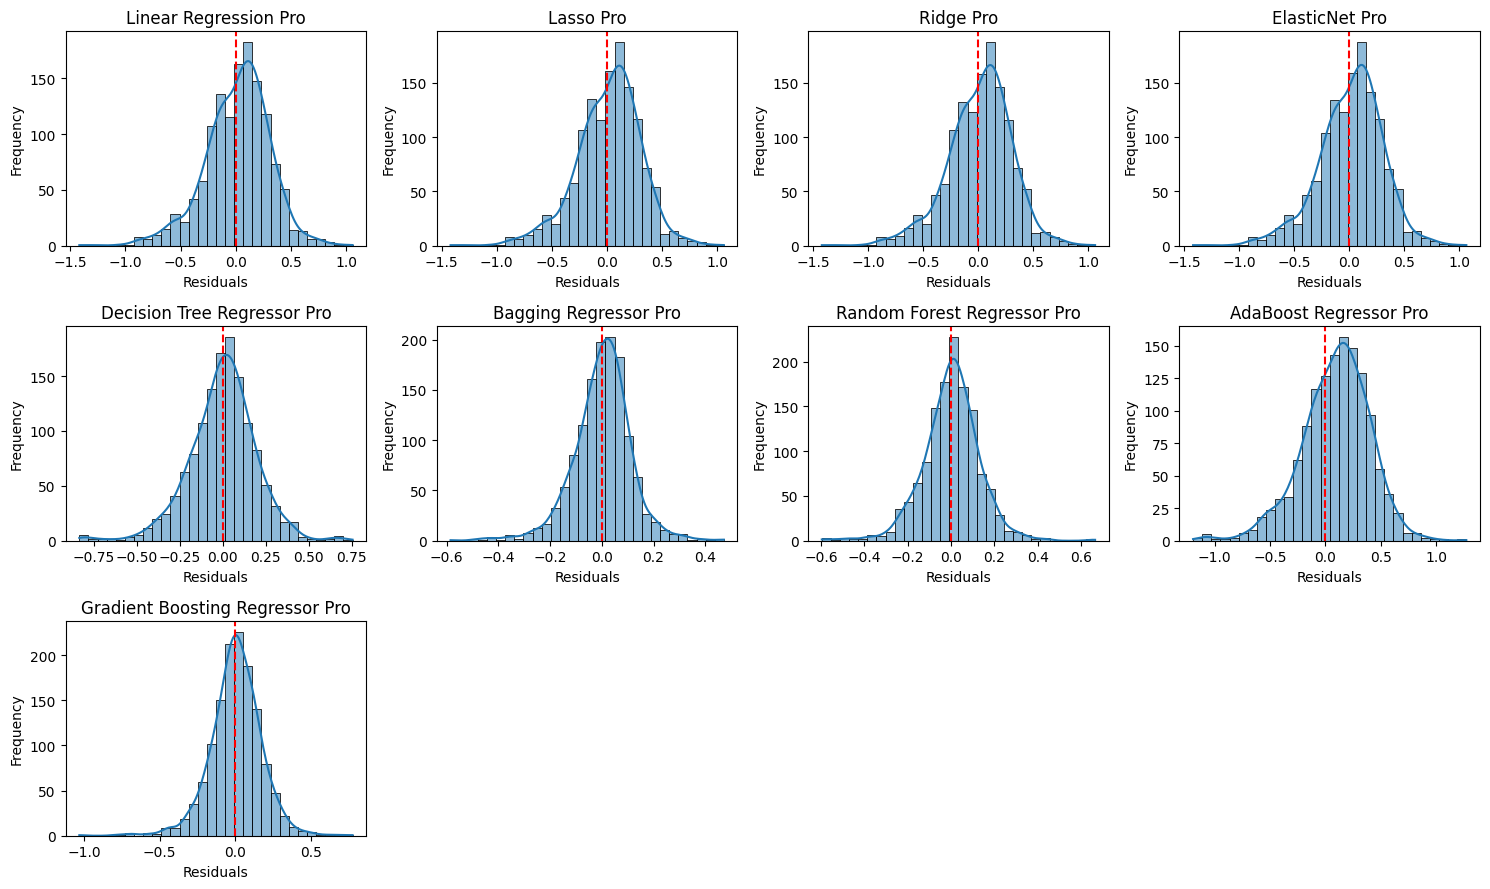

In [441]:
plot_residuals(y_test, y_pred_dict)

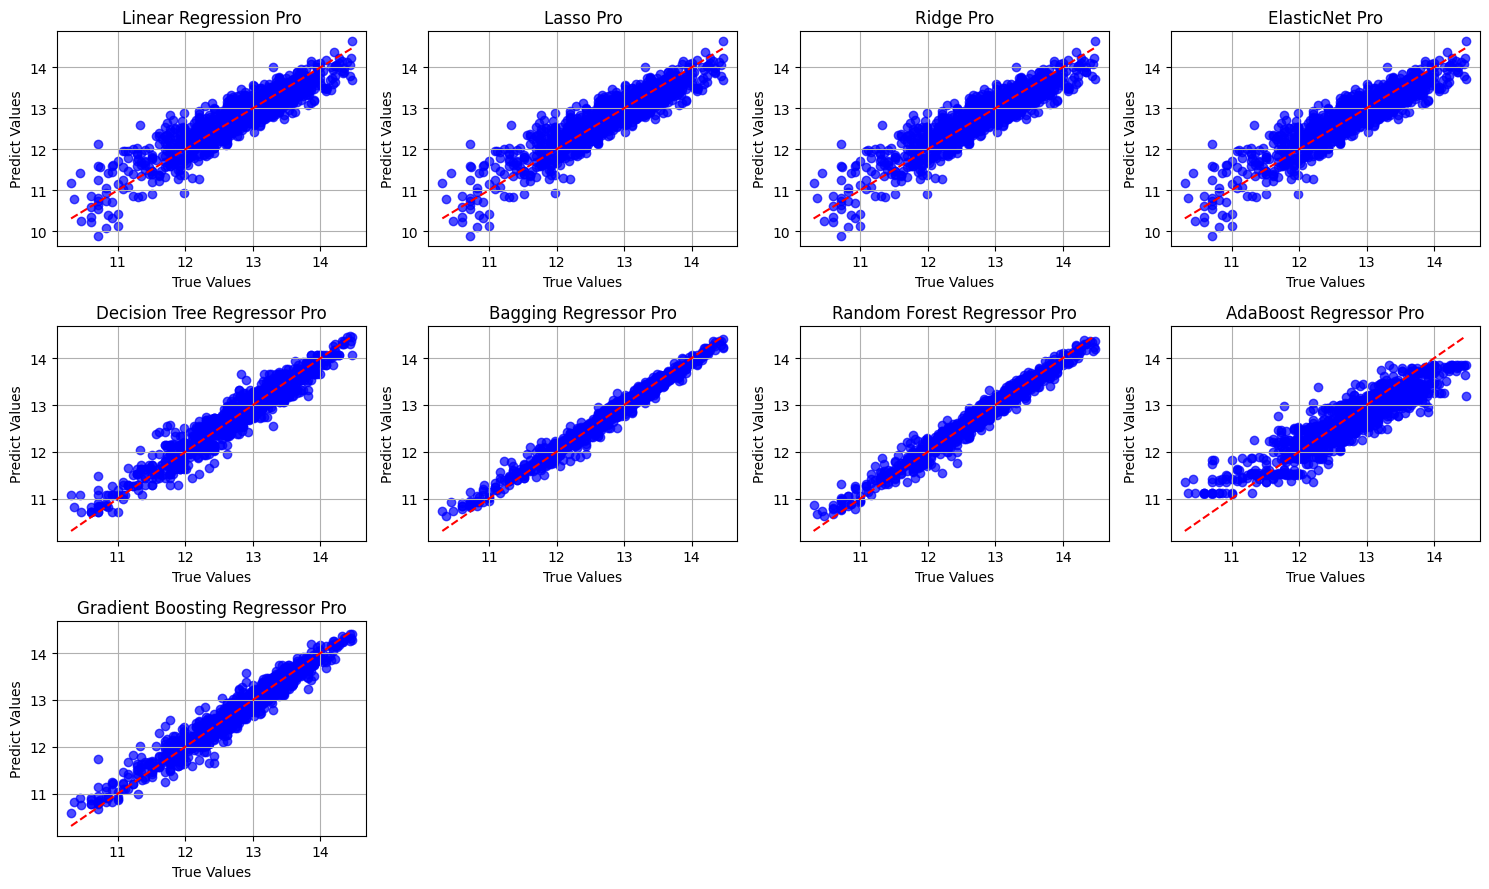

In [442]:
scatter_plot(y_test, y_pred_dict)

### 5.3 Model Validation

#### General Metrics

In [443]:
regression_metrics.sort_values('RMSE')

,Model,MAE,MSE,RMSE,R²,MAPE
14,Bagging Regressor Pro,0.082454,0.012618,0.112331,0.975925,0.006558
15,Random Forest Regressor Pro,0.097061,0.017245,0.131320,0.967097,0.007703
17,Gradient Boosting Regressor Pro,0.125236,0.028716,0.169458,0.945210,0.009914
13,Decision Tree Regressor Pro,0.145032,0.037698,0.194160,0.928073,0.011467
6,Random Forest Regressor,0.165636,0.050741,0.225258,0.903187,0.013143
5,Bagging Regressor,0.171617,0.055772,0.236160,0.893589,0.013595
8,Gradient Boosting Regressor,0.179208,0.057066,0.238884,0.891120,0.014195
9,Linear Regression Pro,0.226908,0.085385,0.292207,0.837088,0.017966
10,Lasso Pro,0.226990,0.085402,0.292236,0.837055,0.017973
12,ElasticNet Pro,0.227127,0.085513,0.292425,0.836844,0.017984


#### KFold

In [444]:
def kfold_regression_validation(x, y, models, n_splits=5, metrics=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']):

    kf = KFold(n_splits=n_splits, shuffle=True)
    results = {metric: {} for metric in metrics}
    
    for metric in metrics:
        for name, model in models.items():
            scores = cross_val_score(model, x, y, cv=kf, scoring=metric)
            results[metric][name] = {'scores': scores, 'mean_score': np.mean(scores)}
    
    num_metrics = len(metrics)
    fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(15, num_metrics * 3))
    
    for i, metric in enumerate(metrics):
        model_names = list(results[metric].keys())
        means = [results[metric][n]['mean_score'] for n in model_names]
        best_model = model_names[np.argmax(means)]
        
        axes[i].bar(model_names, means, color=['lightgreen' if n != best_model else 'red' for n in model_names])
        axes[i].set_ylabel(f"{metric}")
        axes[i].set_title(f"\nModel Comparison for {metric}\nBest model: {best_model}", fontsize=14)
        axes[i].tick_params(axis='x', rotation=10)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

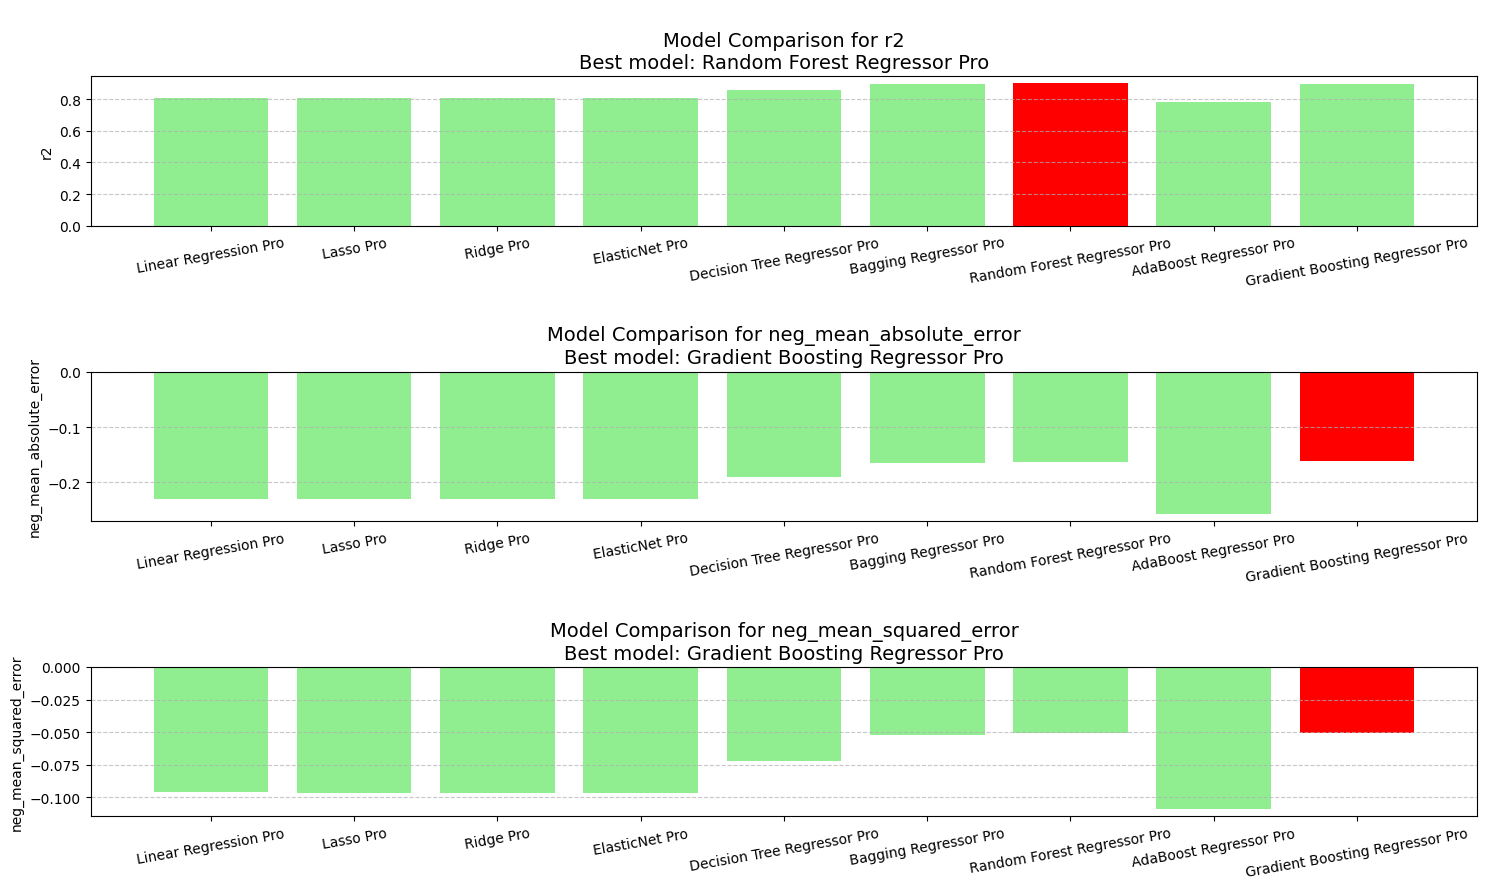

In [445]:
kfold_regression_validation(x, y, models_pro, n_splits=5)

#### Learning Curve

In [446]:
def plot_learning_curves_regression(models, x, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='r2', cols=3):
    num_models = len(models)
    rows = (num_models + cols - 1) // cols  # Calcula el número de filas necesarias
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()  # Asegurar que podemos indexar correctamente los subplots
    
    for idx, (name, model) in enumerate(models.items()):
        train_sizes_, train_scores, test_scores = learning_curve(model, x, y, cv=cv, train_sizes=train_sizes, scoring=scoring)
        
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        ax = axes[idx]
        ax.fill_between(train_sizes_, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
        ax.fill_between(train_sizes_, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax.plot(train_sizes_, train_scores_mean, 'o-', color="r", label="Training score")
        ax.plot(train_sizes_, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        
        ax.set_title(f"Learning Curve - {name}")
        ax.set_xlabel("Training examples")
        ax.set_ylabel("Score")
        ax.legend(loc="best")
        ax.grid()
    
    # Eliminar subplots vacíos si hay más espacios de los necesarios
    for idx in range(num_models, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()


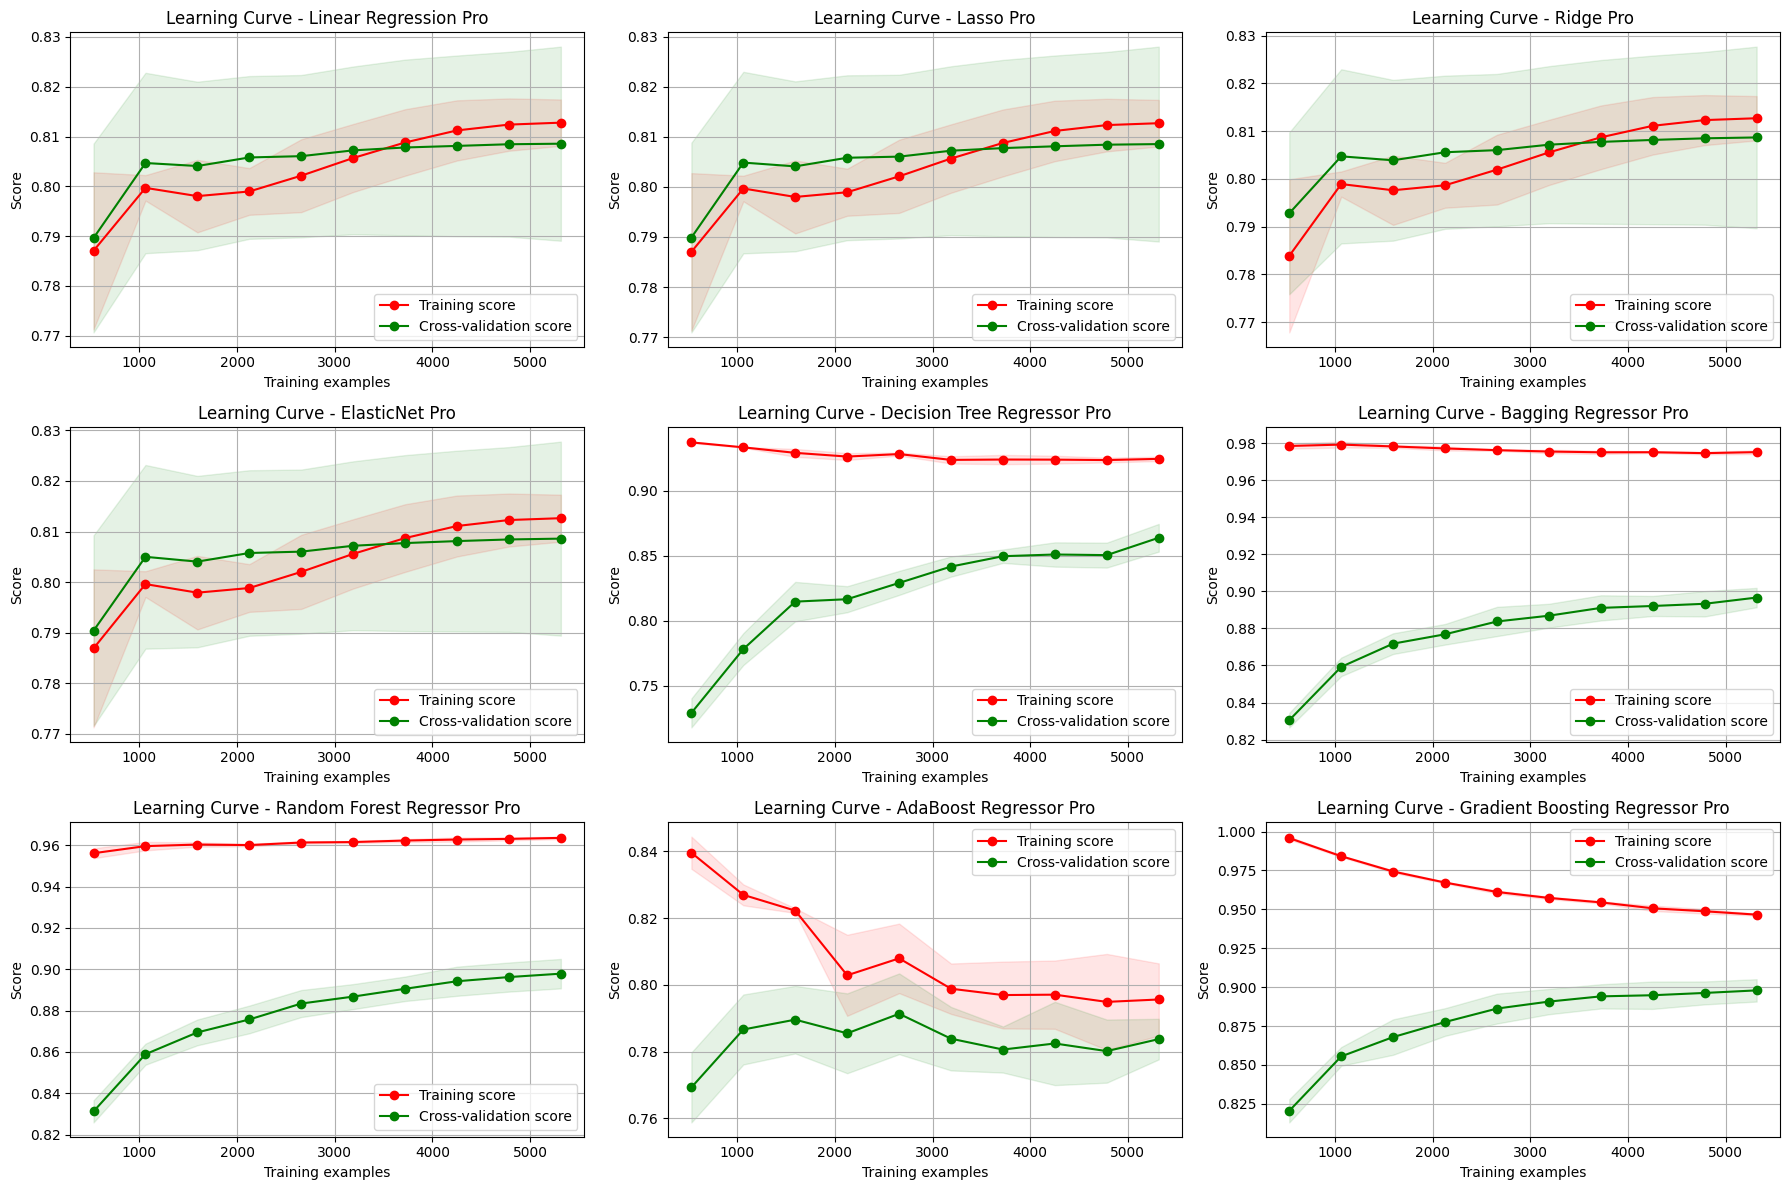

In [447]:
plot_learning_curves_regression(models_pro, x, y)

## 6. Conclusion